In [109]:
# Import Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from typing import Optional, List, Sequence, Union, Mapping, Any


In [110]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,              # change to DEBUG for more details
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [112]:
device

'cpu'

# Import dataset from scikit-learn dataset **make-blobs**

In [113]:
from sklearn.datasets import make_blobs

In [114]:
num_samples = 2000
num_classes = 4
num_features = 2
random_seed = 42

# Create Multi-class data
X_blob, y_blob = make_blobs(
    n_samples=num_samples,
    n_features=num_features,
    centers=num_classes,
    cluster_std=1.5,
    random_state=random_seed
)


In [115]:
X_blob.shape, y_blob.shape

((2000, 2), (2000,))

# Visualize the datasets

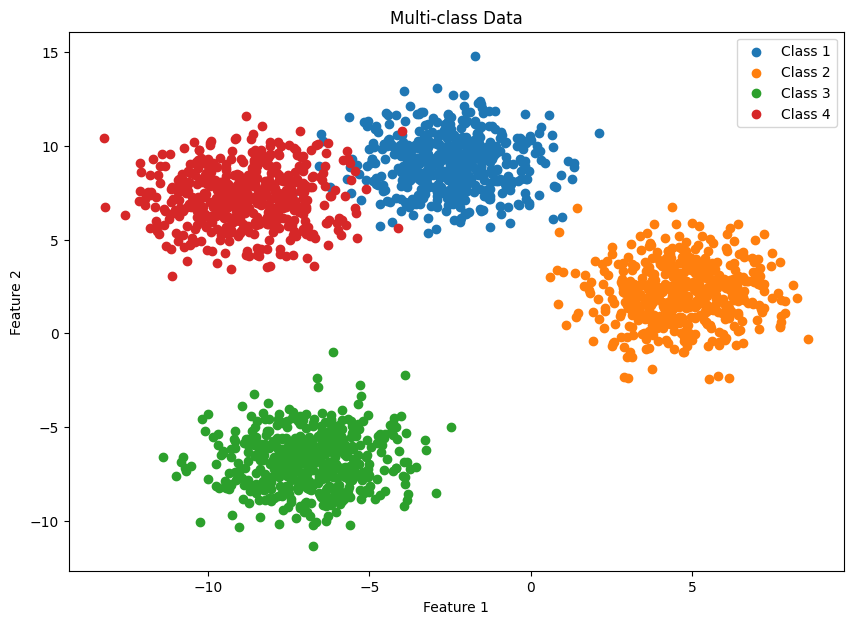

In [116]:
plt.figure(figsize=(10, 7))
colors = plt.cm.tab10.colors
for i in range(num_classes):
    idx = (y_blob == i)
    plt.scatter(X_blob[idx, 0], X_blob[idx, 1], c=[colors[i]], label=f"Class {i+1}") # Pass a single color for each class
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Multi-class Data")
plt.legend()
plt.show()

In [117]:
# Convert to tensors

X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.long)

# Split the dataset into train and test

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

In [119]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 2]),
 torch.Size([400, 2]),
 torch.Size([1600]),
 torch.Size([400]))

In [120]:
y_train.dtype , y_test.dtype

(torch.int64, torch.int64)

# Build a Multi-class Classifciation Model

In [121]:
from typing import Iterable, Optional, Sequence, Union, List, Callable

ModuleLike = Union[nn.Module, Callable[[torch.Tensor], torch.Tensor]]

def _broadcast(value, length: int):
    """Turn a scalar/bool/module into a length-sized list; validate list length."""
    if isinstance(value, Iterable) and not isinstance(value, (str, bytes, nn.Module)):
        value = list(value)
        if len(value) != length:
            raise ValueError(f"Expected list of length {length}, got {len(value)}")
        return value
    return [value for _ in range(length)]

class MultiClassClassifier(nn.Module):
    """
    input_features: int               Number of input features
    output_features: int              Number of output features
    hidden_layers: Sequence[int]      Hidden layer widths, e.g. [128, 64, 32]
    activation_funcs: Module or list  Activation per hidden layer (broadcast if single), e.g. nn.ReLU()
    dropout_probs: float or list      Dropout p per hidden layer (broadcast if single), or 0.0 for none
    batch_norm: bool or list[bool]    Enable BN per hidden layer (broadcast if single), or False/None for none
    out_activation: Optional Module   Optional output activation (e.g. nn.Sigmoid(), nn.Softmax(dim=1))
    """
    def __init__(
        self,
        input_features: int,
        output_features: int,
        hidden_layers: Sequence[int],
        *,
        activation_funcs: Optional[Union[ModuleLike, Sequence[ModuleLike]]] = nn.ReLU(),
        dropout_probs: Optional[Union[float, Sequence[float]]] = 0.0,
        batch_norm: Optional[Union[bool, Sequence[bool]]] = None,
        out_activation: Optional[ModuleLike] = None,
    ):
        super().__init__()

        if not hidden_layers:
            raise ValueError("At least one hidden layer is required.")

        L = len(hidden_layers)

        # Broadcast configs
        acts = _broadcast(activation_funcs if activation_funcs is not None else nn.Identity(), L)
        drops = _broadcast(dropout_probs if dropout_probs is not None else 0.0, L)
        if batch_norm is None:
            bns = [False] * L
        else:
            bns = _broadcast(batch_norm, L)

        # Validate values
        for p in drops:
            if not (0.0 <= float(p) < 1.0):
                raise ValueError(f"Dropout p must be in [0,1), got {p}")

        # Build per-layer blocks
        linears: List[nn.Linear] = []
        bnl: List[nn.BatchNorm1d] = []
        actl: List[nn.Module] = []
        dropl: List[nn.Dropout] = []

        in_f = input_features
        for i, out_f in enumerate(hidden_layers):
            linears.append(nn.Linear(in_f, out_f))
            if bns[i]:
                bnl.append(nn.BatchNorm1d(out_f))
            else:
                bnl.append(nn.Identity())  # keeps indexing simple
            actl.append(acts[i] if isinstance(acts[i], nn.Module) else nn.Identity())
            dropl.append(nn.Dropout(float(drops[i])) if float(drops[i]) > 0 else nn.Identity())
            in_f = out_f

        self.hidden_linears = nn.ModuleList(linears)
        self.hidden_bns     = nn.ModuleList(bnl)
        self.hidden_acts    = nn.ModuleList(actl)
        self.hidden_drops   = nn.ModuleList(dropl)

        self.out = nn.Linear(hidden_layers[-1], output_features)
        self.out_activation = out_activation if isinstance(out_activation, nn.Module) else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for lin, bn, act, drop in zip(self.hidden_linears, self.hidden_bns, self.hidden_acts, self.hidden_drops):
            x = lin(x)
            x = bn(x)
            x = act(x)
            x = drop(x)

        x = self.out(x)
        if self.out_activation is not None:
            x = self.out_activation(x)
        return x


In [122]:
# Function to initialize all paaremeters and gradients
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

    m.zero_grad(set_to_none=True)

In [123]:
# function to create a loss module
def build_loss(
    lossfunc: Union[str, nn.Module, type, None],
    *,
    device: torch.device
) -> nn.Module:
    """Return an instantiated loss module from a string / class / instance."""
    if isinstance(lossfunc, nn.Module):
        return lossfunc


    if lossfunc is None:
        return nn.CrossEntropyLoss()

    if isinstance(lossfunc, type) and issubclass(lossfunc, nn.modules.loss._Loss):
        return lossfunc()

    if isinstance(lossfunc, str):
        name = lossfunc.strip().lower()
        aliases = {
            "ce": "CrossEntropyLoss",
            "cross_entropy": "CrossEntropyLoss",
            "crossentropy": "CrossEntropyLoss",
            "bcewithlogits": "BCEWithLogitsLoss",
            "bce_logits": "BCEWithLogitsLoss",
            "bce": "BCELoss",
            "mse": "MSELoss",
            "l1": "L1Loss",
            "smoothl1": "SmoothL1Loss",
            "huber": "HuberLoss",
            "nll": "NLLLoss",
            "kldiv": "KLDivLoss",
        }

        cls_name = aliases.get(name)
        cls = getattr(nn, cls_name, None) if cls_name else getattr(nn, lossfunc, None)

        # Fallback: try TitleCase + 'Loss' heuristic
        if cls is None:
            guess = "".join(part.capitalize() for part in name.split("_"))
            if not guess.endswith("Loss"): guess += "Loss"
            cls = getattr(nn, guess, None)

        if cls is None or not issubclass(cls, nn.modules.loss._Loss):
            raise ValueError(f"Unknown loss function: {lossfunc!r}")

        return cls()

    raise TypeError("lossfunc must be a string, a loss class, a loss instance, or None.")

In [124]:
# Function to create optimizer
def create_optimizer(
    model: nn.Module,
    optimizer: Union[str, type],
    lr: float = 1e-3,
):

  if isinstance(optimizer, str):
          name = optimizer.strip()
          # small, case-insensitive map for common opts
          opt_map = {
              "sgd": optim.SGD,
              "adam": optim.Adam,
              "adamw": optim.AdamW,
              "rmsprop": optim.RMSprop,
              "adagrad": optim.Adagrad,
          }
          OptClass = opt_map.get(name.lower())
          if OptClass is None:
              # fall back to getattr with exact name if user passed e.g. "AdamW"
              try:
                  OptClass = getattr(optim, name)
              except AttributeError as e:
                  raise ValueError(f"Unknown optimizer '{optimizer}'.") from e
  elif isinstance(optimizer, type):
          OptClass = optimizer
  else:
          raise TypeError("optimizer must be a string name or an optimizer class.")

  optimizer = OptClass(model.parameters(), lr=lr)

  return optimizer

In [125]:
# Function to create the model


def createModel(
    input_features: int,
    output_features: int,
    hidden_layers: Sequence[int],
    *,
    activation_funcs: Union[nn.Module, Sequence[nn.Module]] = nn.ReLU(),
    dropout_probs: Optional[Union[float, Sequence[float]]] = None,
    batch_norm: Optional[Union[bool, Sequence[bool]]] = None,
    out_activation: Optional[nn.Module] = None,
    optimizer: Union[str, type] = "SGD",
    learning_rate: float = 1e-2,
    lossfunc: Union[str, nn.Module, type, None] = None,
    device: Optional[Union[str, torch.device]] = None
):

    model = MultiClassClassifier(input_features=input_features,
                                 output_features=output_features,
                                 hidden_layers=hidden_layers,
                                 activation_funcs=activation_funcs,
                                 dropout_probs=dropout_probs,
                                 batch_norm=batch_norm,
                                 out_activation=out_activation)

    model.apply(init_weights)

    model = model.to(device)

    # choose optimizer
    optimizer = create_optimizer(
                                model=model,
                                optimizer=optimizer,
                                lr=learning_rate
                                )

    criterion = build_loss(lossfunc, device=device)

    return model, optimizer, criterion

# Define an Accuracy Function

In [126]:
def accuracy_fn(y_true, y_pred):
  assert y_true.ndim == y_pred.ndim == 1 and len(y_true) == len(y_pred), 'The pred and true values must be 1D and of same length'
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Train the model

In [127]:
import sys

def trainModel(numepochs,
              input_features: int,
              output_features: int,
              hidden_layers: Sequence[int],
              *,
              activation_funcs: Union[nn.Module, Sequence[nn.Module]] = nn.ReLU(),
              dropout_probs: Optional[Union[float, Sequence[float]]] = None,
              batch_norm: Optional[Union[bool, Sequence[bool]]] = None,
              out_activation: Optional[nn.Module] = None,
              optimizer: Union[str, type] = "SGD",
              learning_rate: float = 1e-2,
              lossfunc: Union[str, nn.Module, type, None] = None,
              device: Optional[Union[str, torch.device]] = None,
          ):

  model, optimizer, criterion = createModel(
    input_features=input_features,
    output_features=output_features,
    hidden_layers=hidden_layers,
    activation_funcs=activation_funcs,
    dropout_probs=dropout_probs,
    batch_norm=batch_norm,
    out_activation=out_activation,
    optimizer=optimizer,
    learning_rate=learning_rate,
    lossfunc=lossfunc,
    device=device
    )

  trainloss, testloss, trainacc, testacc = [], [], [], []


  for epochi in range(numepochs):
    model.train()
    y_preds = model(X_train).squeeze()

    train_loss = criterion(y_preds, y_train)
    trainloss.append(train_loss.detach())

    train_acc = accuracy_fn(y_train,
                            torch.argmax(torch.softmax(y_preds,dim=1),dim=1))

    trainacc.append(train_acc)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()


    model.eval()
    with torch.inference_mode():
      test_preds = model(X_test).squeeze()

    test_loss = criterion(test_preds, y_test)
    testloss.append(test_loss.detach())

    test_acc = accuracy_fn(y_test, torch.argmax(torch.softmax(test_preds,dim=1),dim=1))
    testacc.append(test_acc)

    # if epochi % 100 == 0:
    #   sys.stdout.write(f'\nEpoch: {epochi} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')

  return trainloss, testloss, trainacc, testacc, model


In [128]:
numepochs = 5000
input_features = 2
output_features = 4
hidden_layers = [128, 64, 32]
lossfunc = 'CrossEntropyLoss'
optimizer = 'SGD'
learning_rate = 0.001

trainloss, testloss, trainacc, testacc, model = trainModel(numepochs,
                                                    input_features,
                                                    output_features,
                                                    hidden_layers,
                                                    optimizer=optimizer,
                                                    learning_rate=learning_rate,
                                                    lossfunc=lossfunc)


# Visualize the metrics

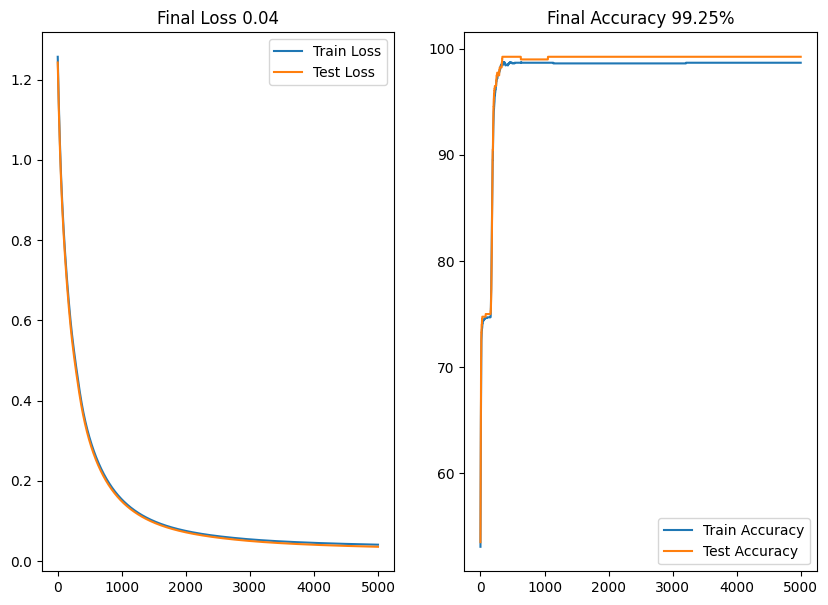

In [129]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.plot(trainloss, label='Train Loss')
plt.plot(testloss, label='Test Loss')
plt.title(f'Final Loss {testloss[-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainacc, label='Train Accuracy')
plt.plot(testacc, label='Test Accuracy')
plt.title(f'Final Accuracy {testacc[-1]}%')
plt.legend()

plt.show();


# Save the model parameters for final evaluation

In [130]:
torch.save(model.state_dict(), 'model_params.pth')

# Visualize the final output

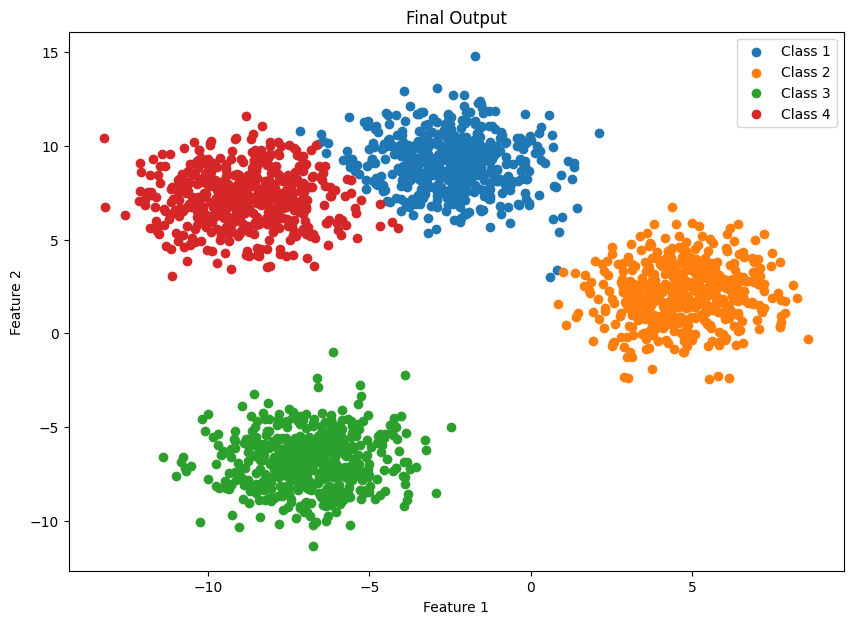

In [131]:
model = MultiClassClassifier(2,4,[128, 64, 32])

model.load_state_dict(torch.load('model_params.pth', map_location=device))
model.eval()
with torch.inference_mode():
    logits = model(torch.tensor(X_blob, dtype=torch.float))
y_preds = logits.argmax(dim=1)

# unique classes predicted
classes = np.unique(y_preds.cpu().numpy())
colors = plt.cm.tab10.colors  # categorical color palette

plt.figure(figsize=(10, 7))
for i, cls  in enumerate(classes):
    idx = (y_preds.cpu().numpy() == i)
    plt.scatter(X_blob[idx, 0], X_blob[idx, 1],
                c=[colors[i]], label=f"Class {cls+1}")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Final Output")
plt.legend()
plt.show();

# Plot the decision bondaries

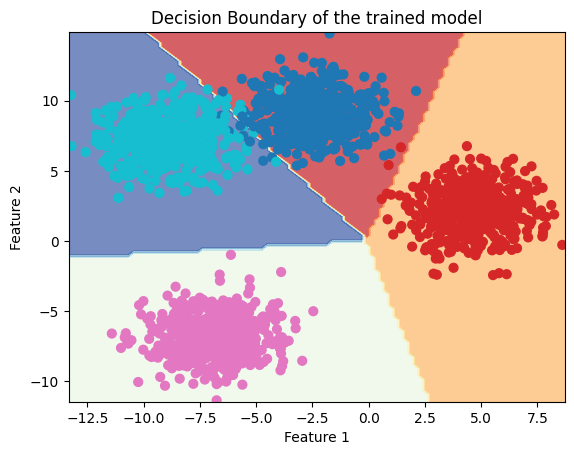

In [150]:
# Setup prediction boundaries and grid
x_min, x_max = X_blob[:, 0].min() - 0.1, X_blob[:, 0].max() + 0.1
y_min, y_max = X_blob[:, 1].min() - 0.1, X_blob[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

# Make predictions on the grid
model.eval()
with torch.inference_mode():
    y_grid_preds = torch.softmax(model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)),dim=1).cpu().numpy()


# Reshape preds and plot
y_grid_preds = np.argmax(y_grid_preds, axis=1).reshape(xx.shape) # Select the class with the highest probability and reshape
plt.contourf(xx, yy, y_grid_preds, cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, s=40, cmap=plt.cm.tab10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary of the trained model")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [155]:
from sklearn.metrics import classification_report

report = classification_report(y_blob, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       500
           1       1.00      0.99      1.00       500
           2       1.00      1.00      1.00       500
           3       0.98      0.98      0.98       500

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [156]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_blob, y_preds)
print(cm)

[[491   0   0   9]
 [  4 496   0   0]
 [  0   0 500   0]
 [ 11   0   0 489]]


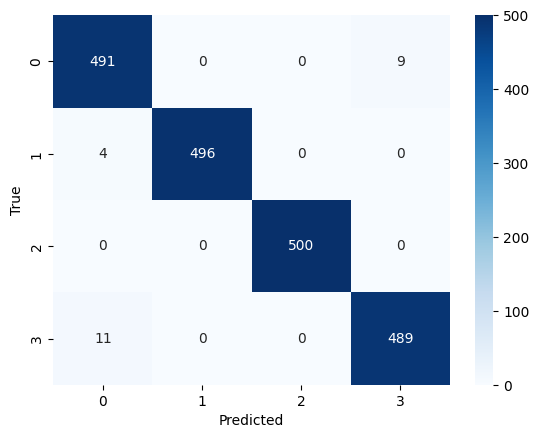

In [157]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()